<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t, chi2_contingency, chi2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data --no-check-certificate


--2020-04-11 16:22:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2020-04-11 16:22:43 (135 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [3]:
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
votes_df = pd.read_csv('house-votes-84.data', na_values='?', header=None, names=column_headers)
votes_df.replace({'n':0, 'y':1}, inplace=True)
votes_df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


We will treat the congressional votes as if they were samples of how the population would vote as a whole on the issues, regardless the political parties. In other words, as if it were a poll on each issue, with a sample size of up to 535 (but dropping abstentions which might be 'don't know' answers).

Considering a vote on an issue as a sample proportion (rather than mean) to approximate the population proportion, as we are looking at binomial data (1 or 0, yes or no). I know this differs from class in the method of calculating standard deviation of error I will use.

Instead of sample mean, then, we will calculate sample proportion:

\begin{equation*}
\hat{p}=\frac{c}n 
\end{equation*}

Where c is the number of 'yes' votes. Thus far it is the same result as calculating the sample mean. However, we  will calculate the sample standard error a different way (as sample proportion rather than mean).

\begin{equation*}
SE = \sqrt{\frac{\hat{p}(1-\hat{p})}n}
\end{equation*}

And from that, we arrive at the confidence interval in the usual way.


\begin{equation*}
CI(a,b)=\hat{p}\pm{t\_{stat}\times SE}
\end{equation*}

**Observations**

As partisan and contentious as some of these issues may have been, the actual margins of the total size of the votes for any of them is surprisingly small. For example, while the budget is often a highly partisan and divided issue between republicans and democrats, the vote only passed by about 9.6% of the whole congress. Given the 95% confidence level, and a margin of error of about 3.92%, were this a representative sample (which is what represntative government is supposed to be), it still may have been passed by the population as a whole by possibly as little as approximately a 5.7% margin.

In [0]:
def proportion_CI(data, conf_level):
  '''
  Calculate sample proportion statistics.

  data: the smaple data
  returns series with statistics for the sample
  '''

  # Basic counts
  n = data.shape[0]
  counts = data.value_counts()
  yes = counts[1.0]
  no = counts[0.0]

  # sample proportion and standard error
  p_hat = sum(data) / n
  SE = np.sqrt(p_hat * (1 - p_hat) / n)

  # margin of error and confidence limits
  t_stat = t.ppf((1 + conf_level) / 2, n-1)
  ME = t_stat * SE
  upper_conf = p_hat + ME
  lower_conf = p_hat - ME 

  # package it all up nicely
  stats = [n, yes, no, p_hat, SE, conf_level, ME, upper_conf, lower_conf]
  results = pd.Series(stats, index=['count', 'yays', 'nays', 'sample proportion', 
                                    'standard err', 'confidence', 'MOE', 
                                    'upper_conf', 'lower_conf'])
  return results

In [0]:
def plotIntervals(data, data_stats):
  '''
  Plot sample data and confidence intervals

  data: the sample data
  data_stats: statistics from proportion_CI()
  cl: confidence level (e.g., 95 if 95%)
  '''

  sns.kdeplot(data)
  plt.axvline(x=data_stats['lower_conf'], color='red')
  plt.axvline(x=data_stats['sample proportion'])
  plt.axvline(x=data_stats['upper_conf'], color='red')
  moe = data_stats['MOE'] * 100
  conf = int(data_stats['confidence'] * 100)
  plt.title(f'{conf}% Confidence, MOE = {round(moe, 3)}%')
  plt.xlim(-.1, 1.1)
  plt.show()

We'll try one though that seems uncontroversial first in terms of the two parties.

count                387.000000
yays                 195.000000
nays                 192.000000
sample proportion      0.503876
standard err           0.025416
confidence             0.950000
MOE                    0.049970
upper_conf             0.553846
lower_conf             0.453905
dtype: float64


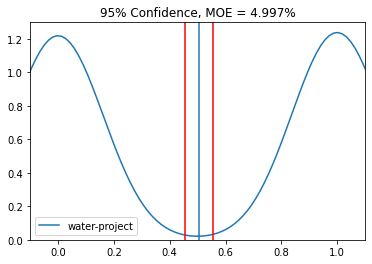

In [40]:
# On each filter, I also chain .dropna to drop any missing data so as to
# not pose problems for my functions.
water_votes = votes_df['water-project'].dropna()
water_stats = proportion_CI(water_votes, 0.95)
print(water_stats)
plotIntervals(water_votes, water_stats)


We'll try the budget (more controversial).

count                424.000000
yays                 253.000000
nays                 171.000000
sample proportion      0.596698
standard err           0.023824
confidence             0.950000
MOE                    0.046828
upper_conf             0.643526
lower_conf             0.549870
dtype: float64


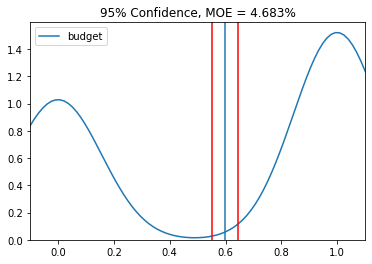

In [41]:
budget_votes = votes_df['budget'].dropna()
budget_stats = proportion_CI(budget_votes, 0.95)
print(budget_stats)
plotIntervals(budget_votes, budget_stats)

And by political parties

Republican votes:
 count                164.000000
yays                  22.000000
nays                 142.000000
sample proportion      0.134146
standard err           0.026613
confidence             0.950000
MOE                    0.052550
upper_conf             0.186697
lower_conf             0.081596
dtype: float64


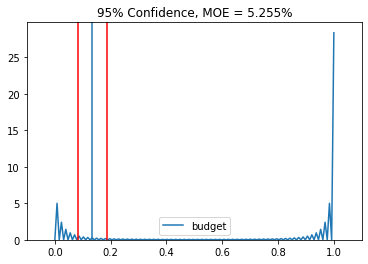


Democratic votes:
 count                260.000000
yays                 231.000000
nays                  29.000000
sample proportion      0.888462
standard err           0.019523
confidence             0.950000
MOE                    0.038444
upper_conf             0.926905
lower_conf             0.850018
dtype: float64


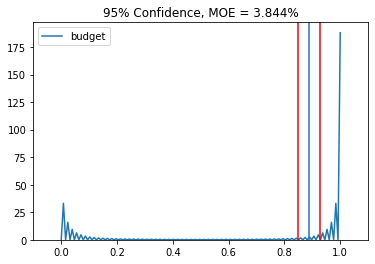

In [42]:
budget_rep = votes_df[votes_df['party'] == 'republican']['budget'].dropna()
budget_dem = votes_df[votes_df['party'] == 'democrat']['budget'].dropna()
budget_rep_stats = proportion_CI(budget_rep, 0.95)
budget_dem_stats = proportion_CI(budget_dem, 0.95)
print("Republican votes:\n", budget_rep_stats)
plotIntervals(budget_rep, budget_rep_stats)
print("\nDemocratic votes:\n", budget_dem_stats)
plotIntervals(budget_dem, budget_dem_stats)

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Write function for Chi Square without Scipy.

\begin{equation*}
\chi^2=\sum\frac{(x_{observed}- x_{expected})^2}{x_{expected}}
\end{equation*}

And compare our results with the Scipy chi-square function.



In [0]:
def our_chi2(cross_data):
  '''
  Calculate chi-square given a crosstab of two categorical values.

  Input:
  cross_data: Pandas crosstab (w/out margins)

  Output:
  chi-square statistic
  '''

  # get the row and column sums
  row_sums = np.array(cross_data.sum(axis=1))
  col_sums = np.array(cross_data.sum(axis=0))
  total = sum(row_sums)

  # construct expected values table
  expected = []
  for i in row_sums:
    row_expected = []
    for j in col_sums:
      row_expected.append((i * j) / total)
    expected.append(row_expected)

  # Convert cross_data and expected into one dimensional np arrays
  expected = np.array(expected).flatten()
  observed = np.array(cross_data).flatten()

  # Calculate Chi_squared
  chi_square = sum((observed - expected) ** 2 / expected)

  # And p-value (which does use scipy.stats.chi2)
  dof = (cross_data.shape[0] - 1) * (cross_data.shape[1] - 1)
  p_value = chi2.pdf(chi_square, dof)

  return chi_square, p_value
  

In [0]:
def compareTests(crossdata):
  '''
  Compare results between our function and Scipy's

  Input:
  crossdata: the crosstab table constructed by Pandas, w/o margins

  Output:
  results of both our function, and Scipy's
  '''

  our_result = our_chi2(crossdata)
  print('Our chi-square statistic: %f p-value %f'  % (our_result[0], our_result[1]))

  result = chi2_contingency(crossdata)
  print("Their chi-square statistic: %f p-value: %f" % (result[0], result[1]))  

Let us revisit the Ames real estate database. We can explore, for example, if neighborhood and house styles are dependent variables (which could reflect matters such as zoning regulations as well as economics), and if sales condition influences the ultimate sale price (which we will categorize).

Null hypothesis = the paired variables are independent, and apparent correlations are just a product of chance.

Alternative hypothesis = variables are dependent, rather than correlations being just by chance.

In both cases, the null hypothesis is rejected. Neighborhood and house style are supported to be related, and sales condition appears to have an effect on sale price ranges.

In [45]:
# load and filter data to just features we are interested in.

url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
Ames_df = pd. read_csv(url)
Ames_df = Ames_df[['Neighborhood', 'HouseStyle', 'SaleCondition', 'SalePrice']]
Ames_df.head()

,Neighborhood,HouseStyle,SaleCondition,SalePrice
0,CollgCr,2Story,Normal,208500
1,Veenker,1Story,Normal,181500
2,CollgCr,2Story,Normal,223500
3,Crawfor,2Story,Abnorml,140000
4,NoRidge,2Story,Normal,250000


In [46]:
# add categorical values for price, loosely based on the quartiles, and
# centering 'midrange' on the median price ($163,000).

price_bins = [34000, 80000, 140000, 180000, 220000, 800000]
price_labels = ['low', 'medium-low', 'midrange', 'medium-high', 'high']
Ames_df['priceRange'] = pd.cut(Ames_df['SalePrice'], bins=price_bins, labels=price_labels)
Ames_df.sample(5)

,Neighborhood,HouseStyle,SaleCondition,SalePrice,priceRange
813,NAmes,1Story,Normal,157900,midrange
40,NAmes,1Story,Abnorml,160000,midrange
989,Somerst,2Story,Partial,197000,medium-high
1147,Crawfor,2Story,Normal,174500,midrange
1306,NridgHt,1Story,Partial,202500,medium-high


In [47]:
# first crosstab, house style and neighborhood.

style_neighbor = pd.crosstab(Ames_df['HouseStyle'], Ames_df['Neighborhood'])
style_neighbor

Neighborhood,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
HouseStyle,,,,,,,,,,,,,,,,,,,,,,,,,
1.5Fin,0,0,0,25,6,0,9,22,1,16,0,4,15,0,1,2,0,33,12,5,1,0,0,2,0
1.5Unf,0,0,0,6,0,0,1,0,0,2,0,0,2,0,0,0,0,2,0,0,1,0,0,0,0
1Story,17,0,0,20,11,91,19,53,11,13,2,32,159,4,35,6,51,33,2,53,28,37,18,23,8
2.5Fin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,4,0,0,0,0,0,0
2.5Unf,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0
2Story,0,2,16,6,8,53,20,14,60,5,8,3,22,5,29,33,26,32,7,5,25,49,7,9,1
SFoyer,0,0,0,0,0,3,0,5,0,0,6,5,6,0,1,0,0,2,0,6,3,0,0,0,0
SLvl,0,0,0,0,3,3,0,6,7,0,1,5,21,0,7,0,0,0,0,5,1,0,0,4,2


In [48]:
compareTests(style_neighbor)

Our chi-square statistic: 1047.260852 p-value 0.000000
Their chi-square statistic: 1047.260852 p-value: 0.000000


In [0]:
# Second crosstab, Sale Condition and price range

condition_price = pd.crosstab(Ames_df['SaleCondition'], Ames_df['priceRange'])
condition_price

priceRange,low,medium-low,midrange,medium-high,high
SaleCondition,,,,,
Abnorml,8,52,21,10,10
AdjLand,0,4,0,0,0
Alloca,1,4,3,2,2
Family,0,10,6,1,3
Normal,30,397,335,194,242
Partial,0,3,22,22,78


In [0]:
compareTests(condition_price)

Our chi-square statistic: 179.872601 p-value 0.000000
Their chi-square statistic: 179.872601 p-value: 0.000000


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish). *Done above*
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here. *Below*
3. Refactor your code so it is elegant, readable, and can be easily run for all issues. *Also done above.*

I'll be using a newer UFO sightings dataset I recently scraped from the NUFORC website. It covers from 1970 to February of this year. It does not have geolocation data (not that it is relevant here anyway), but I'll feature engineer additional categorical variables to look at. Some examples are reiterating my previous project, with new data, which I feel could be appropriate for chi-square testing.

I really am hoping to find some cases that will fail to reject the null hypothesis (that apparent correlation between them is just random noise). That would further test my function (though my results match the Scipy function). But none of these seem independent.

In [0]:
ufo_url = 'https://raw.githubusercontent.com/karencfisher/ufosightings/master/newufo.csv'
ufo_df = pd.read_csv(ufo_url)
ufo_df.head()


,datetime,City,State,Shape,Duration,Summary,Posted
0,2020-02-03 20:00:00,Eastaboga,AL,Unknown,0 days 00:03:00.000000000,Well this has been happening several nights fo...,2/7/20
1,2020-02-02 19:00:00,Chelsea,AL,Oval,0 days 00:30:00.000000000,Coming in from work we could see a white light...,2/7/20
2,2020-02-02 07:30:00,Hueytown,AL,Other,0 days 00:03:00.000000000,Very seriously concerning what I'm seeing righ...,2/7/20
3,2020-02-01 07:00:00,Southside,AL,Light,0 days 00:25:00.000000000,Distant unmoving bright light in sky west of o...,2/7/20
4,2020-01-08 18:00:00,Littleville,AL,Light,0 days 00:00:40.000000000,Two lights floated above the police department...,2/7/20


Create some new categorical variables.

In [0]:
# Need to convert date and time columns to proper formats
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'])
ufo_df['Duration'] = pd.to_timedelta(ufo_df['Duration'])

In [0]:
ufo_df['year'] = ufo_df['datetime'].dt.year
decade_bins = [1970, 1979, 1989, 1999, 2009, 2020]
decade_labels = ['1970-79', '1980-89', '1990-99', '2000-09', '2010-2019']
ufo_df['decade'] = pd.cut(ufo_df['datetime'].dt.year, bins=decade_bins, labels=decade_labels)
ufo_df[['datetime', 'year','decade']].sample(10)

,datetime,year,decade
38056,2012-06-22 01:20:00,2012,2010-2019
8823,2012-07-04 22:00:00,2012,2010-2019
25002,2011-08-27 20:30:00,2011,2010-2019
56591,2009-11-22 18:00:00,2009,2000-09
44865,2014-09-01 20:00:00,2014,2010-2019
15445,2012-09-02 13:00:00,2012,2010-2019
60589,2006-10-24 20:50:00,2006,2000-09
53158,2015-09-22 22:55:00,2015,2010-2019
27376,2019-12-27 22:30:00,2019,2010-2019
25289,2010-06-15 02:30:00,2010,2010-2019


In [0]:
seasons = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer',
           9: 'fall', 10: 'fall', 11: 'fall'}
ufo_df['season'] = ufo_df['datetime'].dt.month.apply(lambda x: seasons[x])
ufo_df[['datetime', 'season']].sample(5)

,datetime,season
20200,2008-06-20 01:00:00,summer
45753,2011-08-30 22:16:00,summer
9220,2011-11-21 02:19:00,fall
22530,1998-09-15 19:00:00,fall
1163,2020-01-30 22:00:00,winter


In [0]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ufo_df['weekday'] = ufo_df['datetime'].apply(lambda x: days_of_week[x.weekday()])
ufo_df[['datetime', 'weekday']].sample(5)

,datetime,weekday
36305,2012-11-07 22:30:00,Wednesday
67307,2016-07-09 21:00:00,Saturday
66742,2019-09-03 22:00:00,Tuesday
65725,2014-04-16 10:30:00,Wednesday
62277,2011-07-29 01:45:00,Friday


In [0]:
timeofday_bins = [0, 4, 8, 12, 16, 20, 24]
timeofday_labels = ['Midnight - 4AM', '4AM - 8AM', '8AM - Noon', 'Noon - 4PM', '4PM - 8PM', '8PM - Midnight']
ufo_df['timeofday'] = pd.cut(ufo_df['datetime'].dt.hour, bins=timeofday_bins, labels=timeofday_labels)
ufo_df[['datetime', 'timeofday']].head()

,datetime,timeofday
0,2020-02-03 20:00:00,4PM - 8PM
1,2020-02-02 19:00:00,4PM - 8PM
2,2020-02-02 07:30:00,4AM - 8AM
3,2020-02-01 07:00:00,4AM - 8AM
4,2020-01-08 18:00:00,4PM - 8PM


Do shapes of the objects seen change from decade to decade?

In [0]:
decades_shapes = pd.crosstab(ufo_df['decade'], ufo_df['Shape'])
decades_shapes

Shape,Changing,Chevron,Cigar,Circle,Cone,Cross,Cylinder,Diamond,Disk,Egg,Fireball,Flash,Formation,Light,Other,Oval,Rectangle,Sphere,Teardrop,Triangle,Unknown
decade,,,,,,,,,,,,,,,,,,,,,
1970-79,7,8,67,125,5,2,21,7,236,11,28,4,14,112,62,73,21,65,3,94,68
1980-89,15,17,37,80,1,2,23,14,125,9,20,4,18,109,76,51,39,80,2,116,63
1990-99,33,21,40,130,3,0,23,15,138,18,63,12,30,191,126,70,35,104,14,280,100
2000-09,432,187,477,1465,74,41,268,228,961,146,839,266,508,3589,1159,824,334,1034,182,1726,1334
2010-2019,1252,610,1045,6626,200,195,809,786,1948,360,5258,1050,1987,11583,3313,2209,954,3870,449,4636,3591


In [0]:
compareTests(decades_shapes)

Our chi-square statistic: 2556.682960 p-value 0.000000
Their chi-square statistic: 2556.682960 p-value: 0.000000


In [0]:
tod_dow = pd.crosstab(ufo_df['timeofday'], ufo_df['weekday'])
tod_dow

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
timeofday,,,,,,,
Midnight - 4AM,1005,921,1225,1185,949,975,960
4AM - 8AM,731,625,654,528,718,694,723
8AM - Noon,612,512,779,631,535,520,536
Noon - 4PM,593,578,769,774,582,557,566
4PM - 8PM,2843,2510,3727,2803,2770,2594,2709
8PM - Midnight,4267,3204,5767,3691,3673,3409,3711


In [0]:
compareTests(tod_dow)

Our chi-square statistic: 339.957276 p-value 0.000000
Their chi-square statistic: 339.957276 p-value: 0.000000


In [0]:
seasons_tod = pd.crosstab(ufo_df['season'], ufo_df['timeofday'])
seasons_tod

timeofday,Midnight - 4AM,4AM - 8AM,8AM - Noon,Noon - 4PM,4PM - 8PM,8PM - Midnight
season,,,,,,
fall,1858,1700,1036,1238,7531,6077
spring,1418,750,942,925,3079,6013
summer,2619,792,1393,1311,3327,12040
winter,1325,1431,754,945,6019,3592


In [0]:
compareTests(seasons_tod)

Our chi-square statistic: 6395.836531 p-value 0.000000
Their chi-square statistic: 6395.836531 p-value: 0.000000


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)